In [1]:
import math
import torch
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# helper functions 

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

# Image

In [3]:
img = Image.open('./low_res_circles.png').convert("L")
# img = Image.open('./7.png')
L = T.Compose([
    T.Resize(56),
    T.ToTensor()
])(img).unsqueeze(0)
Hb = nn.Upsample(scale_factor=1.42, mode='bicubic')(L)
Lb = T.GaussianBlur(11)(Hb)
Lb = F.interpolate(Lb, scale_factor=(1/1.42), mode='bilinear', antialias=True)

torch.Size([56, 56, 1])


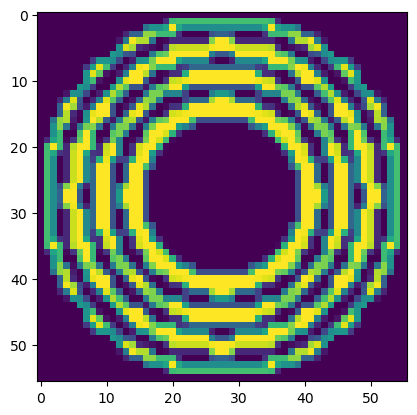

In [4]:
print(L[0].permute(1,2,0).shape)
plt.imshow(L[0].permute(1,2,0))

torch.Size([79, 79, 1])


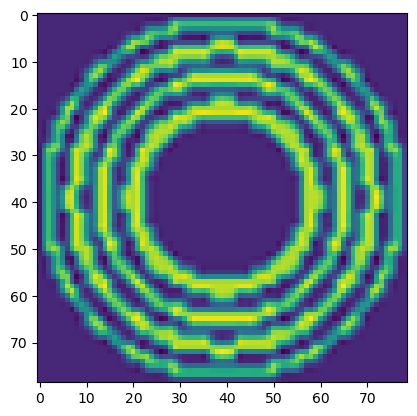

In [5]:
print(Hb[0].permute(1,2,0).shape)
plt.imshow(Hb[0].permute(1,2,0))

torch.Size([55, 55, 1])


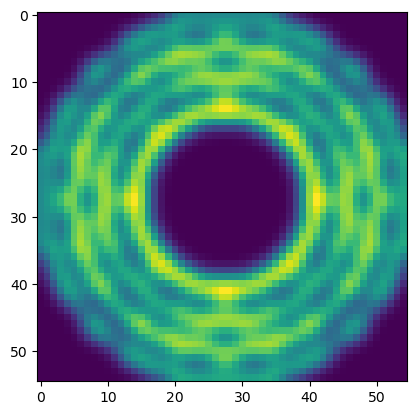

In [6]:
print(Lb[0].permute(1,2,0).shape)
plt.imshow(Lb[0].permute(1,2,0))

# Model

In [8]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
def train(model, neighbors, target):
    model.train()
    model.likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    num_epochs = 100
    for i in range(num_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(neighbors)
        # Calc loss and backprop gradients
        loss = -mll(output, target)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, num_epochs, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

# Deblur function

In [18]:
def get_patches(image, num_channels=1, kernel_size=15, stride=5):
    patches = nn.Unfold(kernel_size=kernel_size, stride=stride)(image)
    batch_size, image_size, grid_size = patches.shape
    grid_width, grid_height = int(math.sqrt(grid_size)), int(math.sqrt(grid_size))
    patches = patches.reshape(1, num_channels, kernel_size, kernel_size, grid_width, grid_height)
    return patches

def get_model_inputs(patch, num_channels=1):
    target = []
    neighbors = []
    input_kernel_size = 3

    batch_size, patch_width, patch_height = patch.shape
    training = nn.Unfold(kernel_size=input_kernel_size, stride=input_kernel_size)(patch)
    training = training.reshape(1, num_channels, input_kernel_size, input_kernel_size, patch_width // 3, patch_height // 3)
    batch_size, num_channels, input_width, input_height, grid_width, grid_height = training.shape

    for i in range(grid_width):
        for j in range(grid_height):
            y = training[:, :, 1, 1, i, j]
            X_NL = training[:, :, :, :, i, j]
            X_NL = X_NL.reshape(num_channels, 1, 9).permute(1, 2, 0)
            X_NL = torch.cat([X_NL[:, :4, :], X_NL[:, 5:, :]], dim=1)

            target.append(y.squeeze())
            neighbors.append(X_NL.squeeze())

    target = torch.stack(target)
    neighbors = torch.stack(neighbors)

    return neighbors, target

def get_neighbors_per_pixel(patch, kernel_size=3, stride=1, padding=1):
    batch_size, width, height = patch.shape
    padded_patch = nn.ReflectionPad2d(padding)(patch)
    neighbors = nn.Unfold(kernel_size=kernel_size, stride=stride)(padded_patch)
    # currently neighbors of edge pixels are not included bc no padding
    neighbors = neighbors.reshape(batch_size, 9, (width + padding*2 - kernel_size + stride)**2)
    neighbors = torch.cat([neighbors[:, :4, :], neighbors[:, 5:, :]], dim=1).permute(0, 2, 1)
    return neighbors

def blend_patch(x0, x1, overlap, direction):
    xh0, xw0 = x0.shape
    xh1, xw1 = x1.shape
    dim_to_overlap = xw0
    other_dim = xh0
    
    if direction == 'v':
        x0 = x0.permute(1, 0)
        x1 = x1.permute(1, 0)
        dim_to_overlap = xh0
        other_dim = xw0

    xramp0 = dim_to_overlap - overlap
    xramp1 = 0

    x00 = x0[:, :xramp0]
    x01 = x0[:, xramp0:]

    x11 = x1[:, :overlap]
    x12 = x1[:, overlap:]

    ramp0 = torch.linspace(1, 0, overlap).repeat((other_dim, 1))
    ramp1 = 1 - ramp0

    blend_mid = x01 * ramp0 + x11 * ramp1

    blend = torch.cat([x00, blend_mid, x12], dim=1)
    
    if direction == 'v':
        blend = blend.permute(1, 0)
    return blend


def blend(patches, overlap, dims):
    h, w = dims
    curr_blend = None
    
    for i in range(h):
        row_blend = patches[i * w]
        for j in range(1, w):
            if w == 0 and h == 0:
                continue
            
            idx = i * w + j

            next_patch = patches[idx]
            row_blend = blend_patch(row_blend, next_patch, overlap, 'h')

        if curr_blend is None:
            curr_blend = row_blend
        else:
            curr_blend = blend_patch(curr_blend, row_blend, overlap, 'v')
    return curr_blend

In [19]:
def deblur(Hb, L, Lb):
    # partition downsampled_upsampled_low_res into n overlapped patches P_1, ..., P_n corresponding to those in low_res
    low_res_patches, hi_res_patches = get_patches(Lb), get_patches(Hb, stride=8)
    batch_size, num_channels, patch_width, patch_height, grid_width, grid_height = low_res_patches.shape

    hi_res_predictions_patches = []
    # for each patch, build y & X_NL and train a GPR model on them
    for i in range(grid_width):
        for j in range(grid_height):
            low_res_patch = low_res_patches[0, :, :, :, i, j]
            hi_res_patch = hi_res_patches[0, :, :, :, i, j]
            train_neighbors, train_target = get_model_inputs(low_res_patch)
            test_neighbors = get_neighbors_per_pixel(hi_res_patch)
            # print("test neighbors shape:", test_neighbors.shape)

            # train a GPR model M using {target, neighbors}
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(train_neighbors, train_target, likelihood)
            # print("train neightors shape:", train_neighbors.shape)
            # print("train target shape:", train_target.shape)
            train(model, train_neighbors, train_target)

            # for each pixel of hi_res_patch, get its eight neighbors and predict the new hi_res pixel
            model.eval()
            likelihood.eval()
            hi_res_prediction_patch = likelihood(model(test_neighbors))
            # print("hi_res_prediction_patch shape:", hi_res_prediction_patch.loc.shape)
            hi_res_predictions_patches.append(hi_res_prediction_patch.loc.squeeze().reshape(15, 15))

    # p_H <- M(X_NH)
    # hi_res_predictions = torch.stack(hi_res_predictions_patches, dim=1).reshape(batch_size, num_channels, patch_width, patch_height, grid_width, grid_height)
    # print("hi_res_predictions shape:", hi_res_predictions.shape)
    # folded_prediction = F.fold(hi_res_predictions.reshape((1,225,81)), Hb.shape[-2:], kernel_size=15, stride=8)
    blended_H = blend(hi_res_predictions_patches, overlap=8, dims=(9,9))
    return hi_res_predictions_patches, blended_H

In [20]:
hi_res_predictions_patches, blended_H = deblur(Hb, L, Lb)

Iter 1/100 - Loss: 0.849   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.808   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.768   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.728   lengthscale: 0.853   noise: 0.554
Iter 5/100 - Loss: 0.688   lengthscale: 0.911   noise: 0.513
Iter 6/100 - Loss: 0.647   lengthscale: 0.969   noise: 0.474
Iter 7/100 - Loss: 0.606   lengthscale: 1.030   noise: 0.437
Iter 8/100 - Loss: 0.564   lengthscale: 1.090   noise: 0.403
Iter 9/100 - Loss: 0.521   lengthscale: 1.152   noise: 0.370
Iter 10/100 - Loss: 0.478   lengthscale: 1.214   noise: 0.340
Iter 11/100 - Loss: 0.434   lengthscale: 1.275   noise: 0.312
Iter 12/100 - Loss: 0.391   lengthscale: 1.336   noise: 0.285
Iter 13/100 - Loss: 0.347   lengthscale: 1.395   noise: 0.261
Iter 14/100 - Loss: 0.303   lengthscale: 1.453   noise: 0.239
Iter 15/100 - Loss: 0.259   lengthscale: 1.509   noise: 0.218
Iter 16/100 - Loss: 0.214   lengthscale: 1.562   noise: 0.198
Iter 17/100 - Los

torch.Size([56, 56, 1])


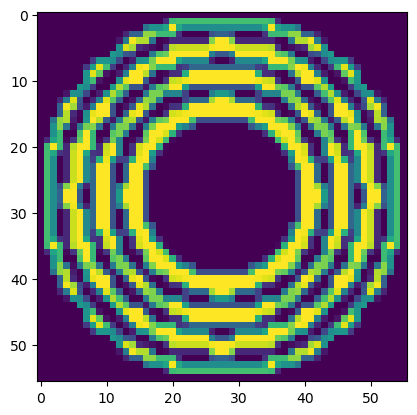

In [21]:
print(L[0].permute(1,2,0).shape)
plt.imshow(L[0].permute(1,2,0))

torch.Size([79, 79, 1])


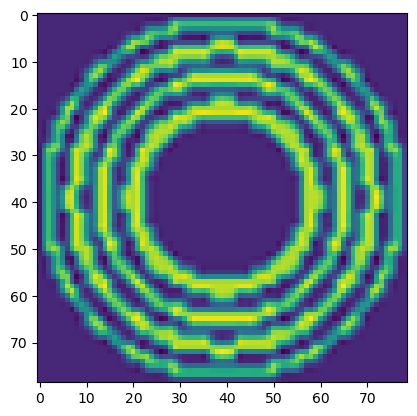

In [22]:
print(Hb[0].permute(1,2,0).shape)
plt.imshow(Hb[0].permute(1,2,0))

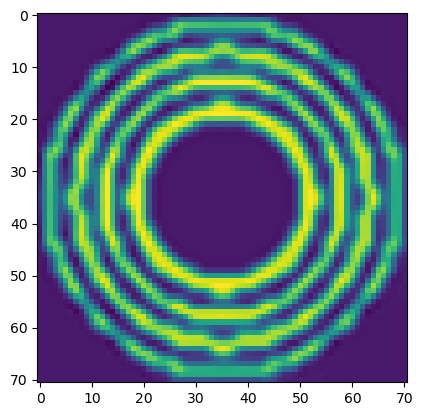

In [23]:
plt.imshow(blended_H.detach().numpy().squeeze())

# Debug help

In [199]:
patches_L_test = nn.Unfold(kernel_size=15, stride=5)(L)
patches_L_test = patches_L_test.reshape(1, 1, 15, 15, 9, 9)

patches_Hb_test = nn.Unfold(kernel_size=15, stride=8)(Hb)
print(patches_Hb_test.shape)
patches_Hb_test = patches_Hb_test.reshape(1, 1, 15, 15, 9, 9)

patches_Lb_test = nn.Unfold(kernel_size=15, stride=5)(Lb)
print(patches_Lb_test.shape)
patches_Lb_test = patches_Lb_test.reshape(1, 1, 15, 15, 9, 9)

torch.Size([1, 225, 81])
torch.Size([1, 225, 81])


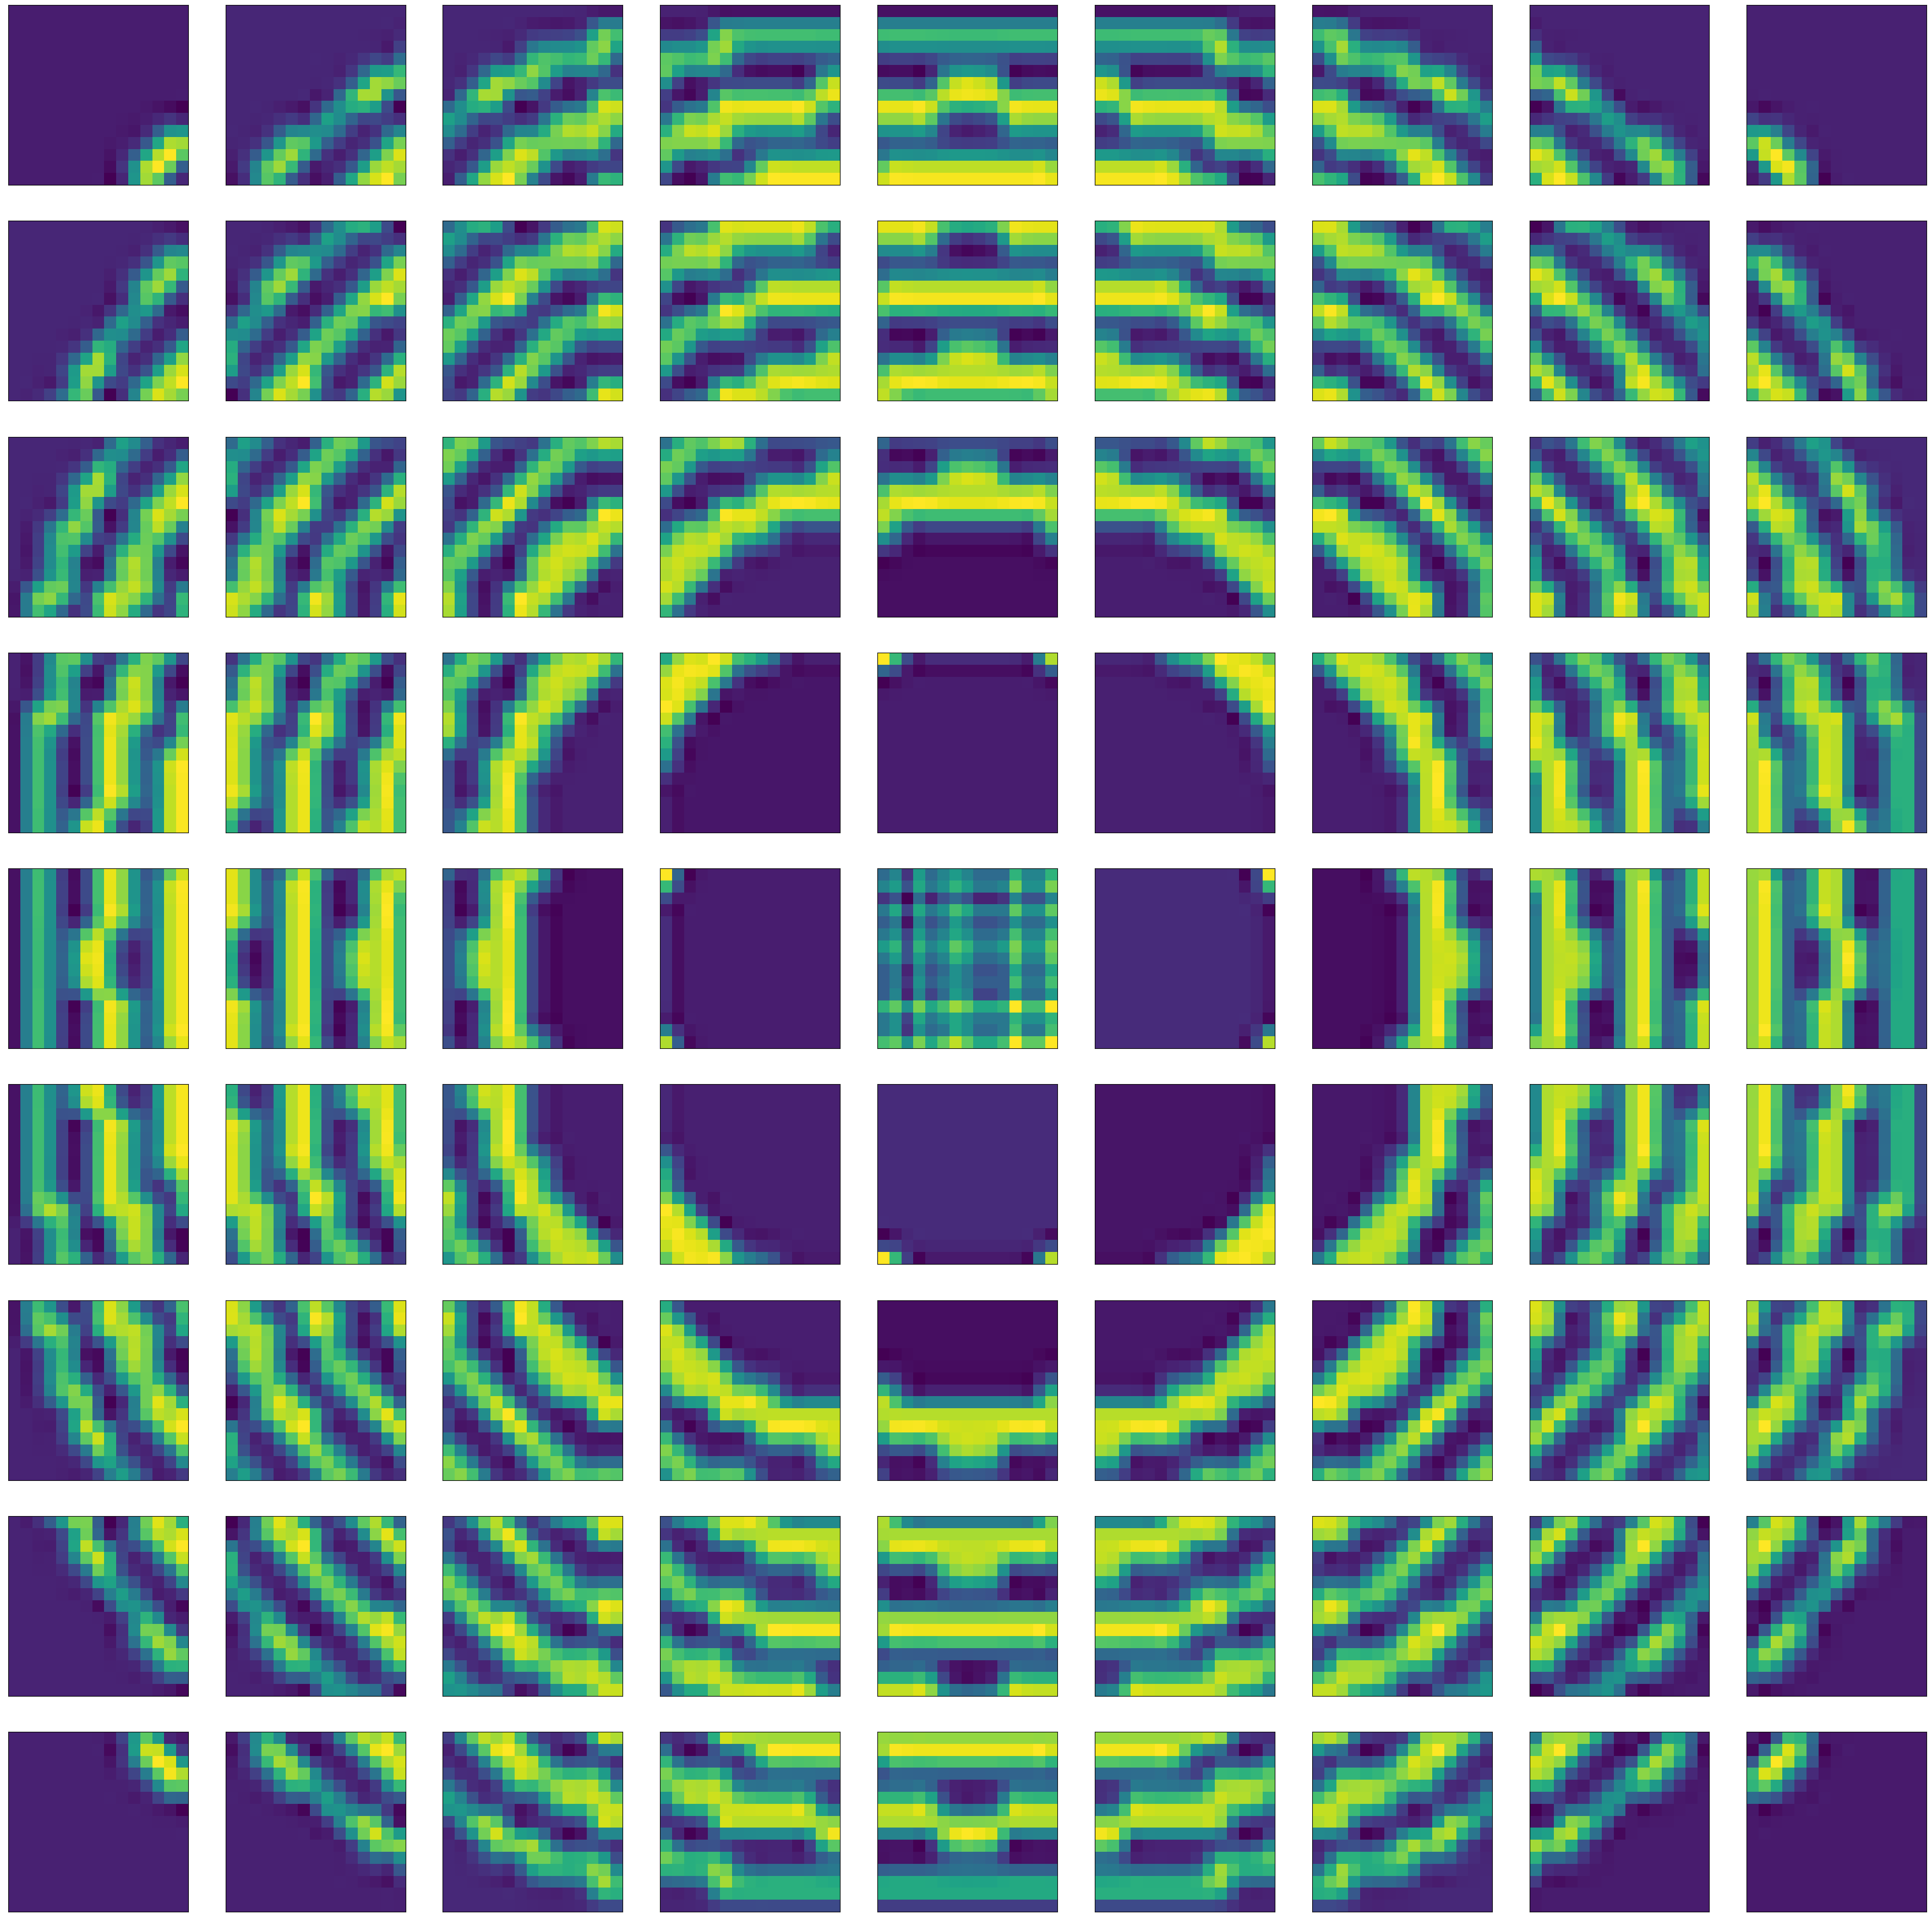

In [200]:
f, ax = plt.subplots(9, 9, figsize=(9*5, 9*5))
for i in range(9):
    for j in range(9):
        ax[i][j].imshow(patches_Hb_test[0, :, :, :, i, j].permute(1, 2, 0))
remove_axes(ax)
plt.show()